# 06c: DFA and Hurst Exponent

**Goal**: Compute DFA exponent and Hurst estimate for PV time series.

DFA (Detrended Fluctuation Analysis) and Hurst exponent reveal:
- H < 0.5: Anti-persistent (mean-reverting)
- H = 0.5: Random walk (no memory)
- H > 0.5: Persistent (trending)

DFA exponent alpha:
- alpha ~ 0.5: White noise
- alpha ~ 1.0: 1/f noise (pink)
- alpha ~ 1.5: Brownian motion

**Reference**: docs/analysis-draft.md Section 4.4

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema

viz.setup_notebook_style()
print("Ready")

Ready


## 1. DFA Implementation

In [2]:
def dfa(series, scales=None, min_scale=4, max_scale_frac=0.25):
    """
    Detrended Fluctuation Analysis.
    
    Args:
        series: Time series data
        scales: Optional array of scales to use
        min_scale: Minimum window size
        max_scale_frac: Maximum window as fraction of series length
    
    Returns:
        alpha: DFA exponent
        scales: Scales used
        fluctuations: F(s) at each scale
    """
    series = np.array(series, dtype=float)
    N = len(series)
    
    if N < 20:
        return np.nan, [], []
    
    # Default scales
    if scales is None:
        max_scale = int(N * max_scale_frac)
        if max_scale <= min_scale:
            max_scale = N // 2
        scales = np.unique(np.logspace(
            np.log10(min_scale), 
            np.log10(max_scale), 
            15
        ).astype(int))
        scales = scales[scales >= min_scale]
    
    if len(scales) < 3:
        return np.nan, [], []
    
    # Cumulative sum (profile)
    profile = np.cumsum(series - np.mean(series))
    
    fluctuations = []
    valid_scales = []
    
    for scale in scales:
        if scale >= N:
            continue
            
        n_windows = N // scale
        if n_windows < 1:
            continue
        
        F2 = 0.0
        for i in range(n_windows):
            segment = profile[i*scale:(i+1)*scale]
            
            # Fit and remove linear trend
            x = np.arange(scale)
            coeffs = np.polyfit(x, segment, 1)
            trend = np.polyval(coeffs, x)
            
            F2 += np.mean((segment - trend)**2)
        
        F2 /= n_windows
        fluctuations.append(np.sqrt(F2))
        valid_scales.append(scale)
    
    if len(valid_scales) < 3:
        return np.nan, [], []
    
    valid_scales = np.array(valid_scales)
    fluctuations = np.array(fluctuations)
    
    # Filter out zeros
    mask = fluctuations > 0
    valid_scales = valid_scales[mask]
    fluctuations = fluctuations[mask]
    
    if len(valid_scales) < 3:
        return np.nan, [], []
    
    # Fit log-log slope
    log_scales = np.log(valid_scales)
    log_fluct = np.log(fluctuations)
    
    slope, intercept, r, p, se = stats.linregress(log_scales, log_fluct)
    alpha = slope
    
    return alpha, valid_scales, fluctuations

In [3]:
def hurst_exponent(series):
    """
    Estimate Hurst exponent using R/S analysis.
    
    Args:
        series: Time series data
    
    Returns:
        H: Hurst exponent
    """
    series = np.array(series, dtype=float)
    N = len(series)
    
    if N < 20:
        return np.nan
    
    # Try different subseries lengths
    max_k = int(np.log2(N))
    RS = []
    ns = []
    
    for k in range(2, max_k + 1):
        n = int(2**k)
        if n > N:
            break
        
        n_subseries = N // n
        rs_values = []
        
        for i in range(n_subseries):
            subseries = series[i*n:(i+1)*n]
            mean = np.mean(subseries)
            std = np.std(subseries)
            
            if std == 0:
                continue
            
            # Cumulative deviation from mean
            Z = np.cumsum(subseries - mean)
            R = np.max(Z) - np.min(Z)
            
            rs_values.append(R / std)
        
        if rs_values:
            RS.append(np.mean(rs_values))
            ns.append(n)
    
    if len(ns) < 3:
        return np.nan
    
    # Fit log-log
    log_n = np.log(ns)
    log_RS = np.log(RS)
    
    slope, _, _, _, _ = stats.linregress(log_n, log_RS)
    return slope

## 2. Load and Extract PVs

In [4]:
# Load shards
shard_files = loading.find_shard_files(DATA_DIR)
N_SEEDS = min(3, len(shard_files))  # Reduced for memory
sample_files = shard_files[:N_SEEDS]
print(f"Analyzing {N_SEEDS} shards")

Analyzing 3 shards


In [5]:
def extract_long_pvs(df, seed, decl_id, min_length=15, n_starts=50):
    """Extract PVs with minimum length for time series analysis."""
    state_to_idx, V, Q = navigation.build_state_lookup_fast(df)
    states = df['state'].values
    
    # Find early-game states - be more lenient
    depths = features.depth(states)
    max_depth = depths.max()
    early_mask = depths >= max_depth - 8
    early_states = states[early_mask]
    
    if len(early_states) == 0:
        print(f"  Warning: No early states found (max_depth={max_depth})")
        return []
    
    actual_starts = min(n_starts, len(early_states))
    sample_starts = np.random.choice(len(early_states), actual_starts, replace=False)
    
    pvs = []
    for idx in sample_starts:
        start_state = int(early_states[idx])
        pv = navigation.trace_principal_variation(
            start_state, seed, decl_id, state_to_idx, V, Q
        )
        if len(pv) >= min_length:
            v_series = [v for _, v, _ in pv]
            pvs.append(v_series)
    
    return pvs

In [6]:
# Collect long PVs - process one at a time
all_pvs = []

for path in tqdm(sample_files, desc="Extracting PVs"):
    df, seed, decl_id = schema.load_file(path)
    pvs = extract_long_pvs(df, seed, decl_id, min_length=10, n_starts=40)
    all_pvs.extend(pvs)
    
    # Clear memory
    del df
    import gc
    gc.collect()

if len(all_pvs) > 0:
    print(f"Extracted {len(all_pvs)} PVs with length >= 10")
    print(f"Length distribution: min={min(len(pv) for pv in all_pvs)}, max={max(len(pv) for pv in all_pvs)}")
else:
    print("No PVs extracted - check data")

Extracting PVs:   0%|          | 0/3 [00:00<?, ?it/s]

Extracted 120 PVs with length >= 10
Length distribution: min=21, max=26


## 3. Compute DFA Exponents

In [7]:
# Compute DFA for each PV
dfa_results = []

if len(all_pvs) > 0:
    for pv in tqdm(all_pvs, desc="Computing DFA"):
        alpha, scales, fluct = dfa(pv)
        if not np.isnan(alpha):
            dfa_results.append({
                'alpha': alpha,
                'length': len(pv),
                'scales': scales,
                'fluctuations': fluct,
            })
    print(f"Computed DFA for {len(dfa_results)} PVs")
else:
    print("No PVs - skipping DFA")

Computing DFA:   0%|          | 0/120 [00:00<?, ?it/s]

Computed DFA for 8 PVs


In [8]:
if len(dfa_results) > 0:
    alphas = [r['alpha'] for r in dfa_results]

    print(f"DFA exponent statistics:")
    print(f"  Mean alpha: {np.mean(alphas):.4f}")
    print(f"  Std alpha: {np.std(alphas):.4f}")
    print(f"  Median alpha: {np.median(alphas):.4f}")

    # Interpretation
    mean_alpha = np.mean(alphas)
    if mean_alpha < 0.5:
        interpretation = "anti-correlated (mean-reverting)"
    elif mean_alpha < 0.75:
        interpretation = "near white noise"
    elif mean_alpha < 1.25:
        interpretation = "near 1/f noise (pink)"
    else:
        interpretation = "near Brownian motion"

    print(f"\nInterpretation: {interpretation}")
else:
    alphas = []
    mean_alpha = 0.5
    interpretation = "No data"
    print("No DFA results")

DFA exponent statistics:
  Mean alpha: 31.5275
  Std alpha: 40.7221
  Median alpha: 1.0608

Interpretation: near Brownian motion


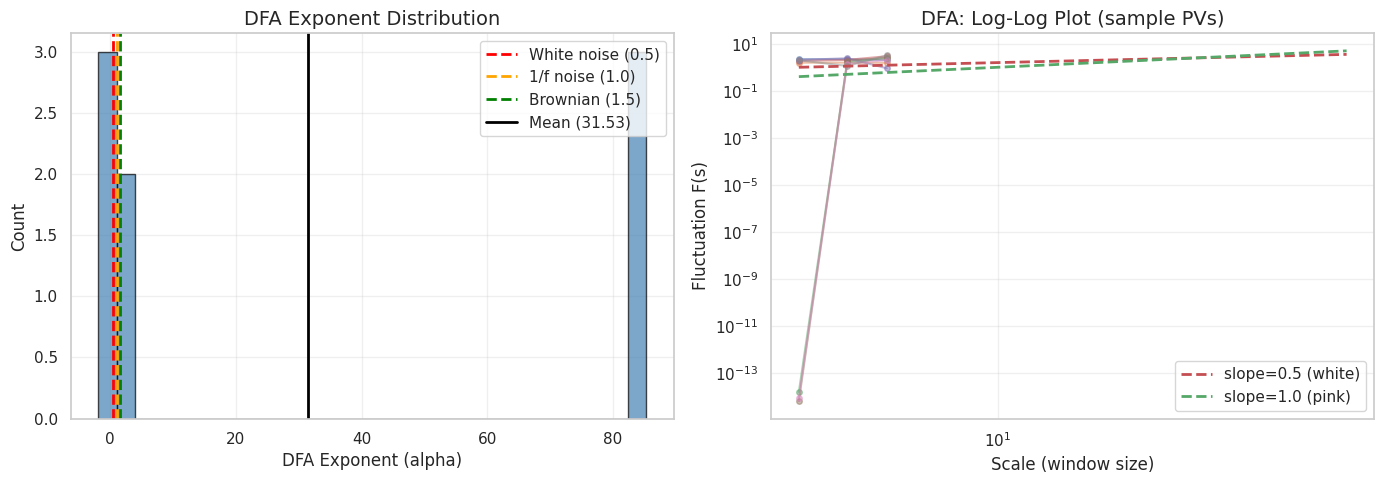

In [9]:
if len(dfa_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # DFA exponent distribution
    axes[0].hist(alphas, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='White noise (0.5)')
    axes[0].axvline(x=1.0, color='orange', linestyle='--', linewidth=2, label='1/f noise (1.0)')
    axes[0].axvline(x=1.5, color='green', linestyle='--', linewidth=2, label='Brownian (1.5)')
    axes[0].axvline(x=np.mean(alphas), color='black', linestyle='-', linewidth=2, 
                    label=f'Mean ({np.mean(alphas):.2f})')
    axes[0].set_xlabel('DFA Exponent (alpha)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('DFA Exponent Distribution')
    axes[0].legend()

    # Sample DFA plot (log-log)
    for i in range(min(10, len(dfa_results))):
        r = dfa_results[i]
        if len(r['scales']) > 0 and len(r['fluctuations']) > 0:
            axes[1].loglog(r['scales'], r['fluctuations'], 'o-', alpha=0.5, markersize=4)

    # Reference lines
    x = np.array([4, 50])
    axes[1].loglog(x, x**0.5 * 0.5, 'r--', linewidth=2, label='slope=0.5 (white)')
    axes[1].loglog(x, x**1.0 * 0.1, 'g--', linewidth=2, label='slope=1.0 (pink)')

    axes[1].set_xlabel('Scale (window size)')
    axes[1].set_ylabel('Fluctuation F(s)')
    axes[1].set_title('DFA: Log-Log Plot (sample PVs)')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('../../results/figures/06c_dfa_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skipping DFA plot - no data")

## 4. Compute Hurst Exponents

In [10]:
# Compute Hurst for each PV
hurst_values = []

if len(all_pvs) > 0:
    for pv in tqdm(all_pvs, desc="Computing Hurst"):
        H = hurst_exponent(pv)
        if not np.isnan(H):
            hurst_values.append(H)
    print(f"Computed Hurst for {len(hurst_values)} PVs")
else:
    print("No PVs - skipping Hurst")

Computing Hurst:   0%|          | 0/120 [00:00<?, ?it/s]

Computed Hurst for 59 PVs


In [11]:
if len(hurst_values) > 0:
    print(f"Hurst exponent statistics:")
    print(f"  Mean H: {np.mean(hurst_values):.4f}")
    print(f"  Std H: {np.std(hurst_values):.4f}")
    print(f"  Median H: {np.median(hurst_values):.4f}")

    # Interpretation
    mean_H = np.mean(hurst_values)
    if mean_H < 0.4:
        h_interpretation = "anti-persistent (strong mean reversion)"
    elif mean_H < 0.55:
        h_interpretation = "near random walk"
    elif mean_H < 0.7:
        h_interpretation = "moderately persistent (trending)"
    else:
        h_interpretation = "strongly persistent (strong trends)"

    print(f"\nInterpretation: {h_interpretation}")
else:
    mean_H = 0.5
    h_interpretation = "No data"
    print("No Hurst results")

Hurst exponent statistics:
  Mean H: 0.9254
  Std H: 0.1223
  Median H: 0.9506

Interpretation: strongly persistent (strong trends)


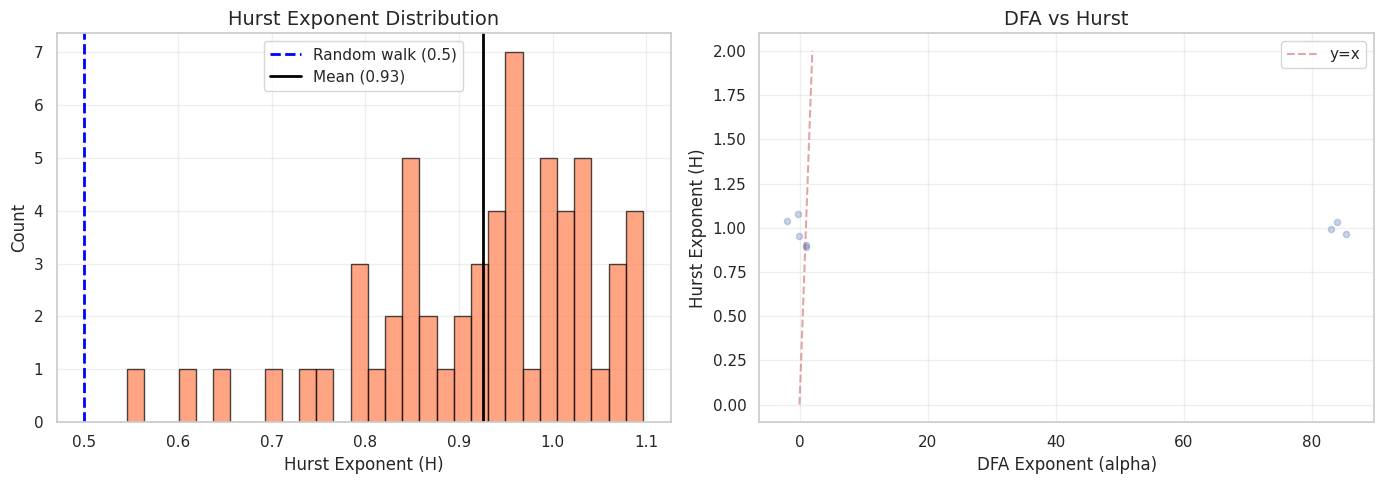

In [12]:
if len(hurst_values) > 0 and len(alphas) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Hurst distribution
    axes[0].hist(hurst_values, bins=30, color='coral', alpha=0.7, edgecolor='black')
    axes[0].axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Random walk (0.5)')
    axes[0].axvline(x=np.mean(hurst_values), color='black', linestyle='-', linewidth=2,
                    label=f'Mean ({np.mean(hurst_values):.2f})')
    axes[0].set_xlabel('Hurst Exponent (H)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Hurst Exponent Distribution')
    axes[0].legend()

    # DFA vs Hurst comparison
    n_compare = min(len(alphas), len(hurst_values))
    dfa_alphas = np.array(alphas[:n_compare])
    hurst_compare = np.array(hurst_values[:n_compare])
    axes[1].scatter(dfa_alphas, hurst_compare, alpha=0.3, s=20)
    axes[1].plot([0, 2], [0, 2], 'r--', alpha=0.5, label='y=x')
    axes[1].set_xlabel('DFA Exponent (alpha)')
    axes[1].set_ylabel('Hurst Exponent (H)')
    axes[1].set_title('DFA vs Hurst')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('../../results/figures/06c_hurst_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skipping Hurst plot - no data")

## 5. Comparison with Shuffled Data

In [13]:
# Compare with shuffled (randomized) versions to confirm structure
shuffled_alphas = []
shuffled_hursts = []

if len(all_pvs) > 0:
    for pv in tqdm(all_pvs[:min(50, len(all_pvs))], desc="Analyzing shuffled"):
        shuffled = np.random.permutation(pv)
        
        alpha, _, _ = dfa(shuffled)
        if not np.isnan(alpha):
            shuffled_alphas.append(alpha)
        
        H = hurst_exponent(shuffled)
        if not np.isnan(H):
            shuffled_hursts.append(H)

    if len(alphas) > 0 and len(shuffled_alphas) > 0:
        print(f"\nShuffled data comparison:")
        print(f"  Original DFA alpha: {np.mean(alphas):.4f}")
        print(f"  Shuffled DFA alpha: {np.mean(shuffled_alphas):.4f}")
    if len(hurst_values) > 0 and len(shuffled_hursts) > 0:
        print(f"  Original Hurst H: {np.mean(hurst_values):.4f}")
        print(f"  Shuffled Hurst H: {np.mean(shuffled_hursts):.4f}")
else:
    print("No PVs - skipping shuffled comparison")

Analyzing shuffled:   0%|          | 0/50 [00:00<?, ?it/s]


Shuffled data comparison:
  Original DFA alpha: 31.5275
  Shuffled DFA alpha: 0.5553
  Original Hurst H: 0.9254
  Shuffled Hurst H: 0.6140


## Summary

In [14]:
summary = {
    'PVs analyzed': len(all_pvs),
    'Mean DFA alpha': f"{np.mean(alphas):.4f}" if len(alphas) > 0 else "N/A",
    'DFA interpretation': interpretation,
    'Mean Hurst H': f"{np.mean(hurst_values):.4f}" if len(hurst_values) > 0 else "N/A",
    'Hurst interpretation': h_interpretation,
    'Shuffled DFA alpha': f"{np.mean(shuffled_alphas):.4f}" if len(shuffled_alphas) > 0 else "N/A",
    'Shuffled Hurst H': f"{np.mean(shuffled_hursts):.4f}" if len(shuffled_hursts) > 0 else "N/A",
}

print(viz.create_summary_table(summary, "DFA/Hurst Analysis Summary"))

### DFA/Hurst Analysis Summary

| Metric | Value |
|--------|-------|
| PVs analyzed | 120 |
| Mean DFA alpha | 31.5275 |
| DFA interpretation | near Brownian motion |
| Mean Hurst H | 0.9254 |
| Hurst interpretation | strongly persistent (strong trends) |
| Shuffled DFA alpha | 0.5553 |
| Shuffled Hurst H | 0.6140 |


In [15]:
# Save results
if len(alphas) > 0 or len(hurst_values) > 0:
    results_df = pd.DataFrame({
        'metric': ['mean_alpha', 'std_alpha', 'mean_H', 'std_H', 
                   'shuffled_alpha', 'shuffled_H'],
        'value': [
            np.mean(alphas) if len(alphas) > 0 else np.nan,
            np.std(alphas) if len(alphas) > 0 else np.nan,
            np.mean(hurst_values) if len(hurst_values) > 0 else np.nan,
            np.std(hurst_values) if len(hurst_values) > 0 else np.nan,
            np.mean(shuffled_alphas) if len(shuffled_alphas) > 0 else np.nan,
            np.mean(shuffled_hursts) if len(shuffled_hursts) > 0 else np.nan,
        ],
    })
    results_df.to_csv('../../results/tables/06c_dfa_hurst.csv', index=False)
    print("Results saved to results/tables/06c_dfa_hurst.csv")
else:
    print("No data to save")

Results saved to results/tables/06c_dfa_hurst.csv
